In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import squarify

from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

In [2]:
X = pd.read_csv('rfs.csv', index_col = 0)

In [3]:
X.head()

,Recency,Frequency,Monetary
CustomerID,,,
14911.0,1,188,70245.51
14096.0,4,17,31267.34
17841.0,1,123,30100.22
13089.0,4,76,23774.91
12748.0,0,193,19402.70


# rfm data

In [4]:
list_sil = []   #danh sach gia tri sil
K = range(2,15)  #danh sach k
for k in K:
  gmm = GaussianMixture(n_components=k)
  gmm.fit(X)
  labels = gmm.predict(X)
  sil = metrics.silhouette_score(X, labels, metric = 'euclidean')
  list_sil.append(sil)

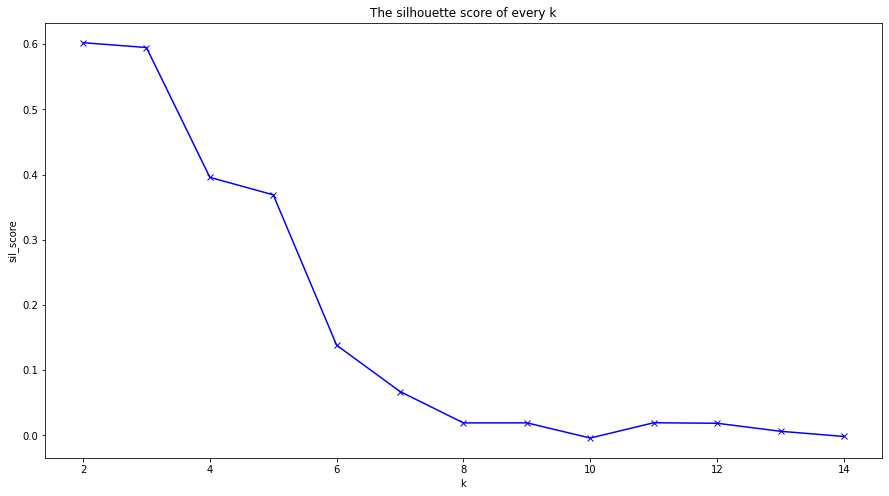

In [5]:
plt.figure(figsize = (15,8))
plt.plot(K, list_sil, 'bx-')
plt.xlabel('k')
plt.ylabel('sil_score')
plt.title('The silhouette score of every k')
plt.show()

Choose k = 4 for data

In [6]:
#select k = 4
gmm = GaussianMixture(n_components=4)
gmm.fit(X)

GaussianMixture(n_components=4)

In [7]:
print('==============Density==============')
print(gmm.weights_)                           #Density can bang nhau (nen)
print('==============Mean==============')
print(gmm.means_)
print('==============Covariance==============')
print(gmm.covariances_)

==============Density==============
[5.16634674e-01 3.91630382e-01 9.14936899e-02 2.41254524e-04]
==============Mean==============
[[1.42583420e+02 1.41360079e+00 2.35767256e+02]
 [4.59476048e+01 4.49347345e+00 9.86388544e+02]
 [1.10919359e+01 1.51184794e+01 3.53755976e+03]
 [1.00000000e+00 1.88000000e+02 7.02455100e+04]]
==============Covariance==============
[[[ 1.23062941e+04 -1.33086645e+01 -2.15683924e+03]
  [-1.33086645e+01  3.62503866e-01  3.98487300e+01]
  [-2.15683924e+03  3.98487300e+01  2.76128359e+04]]

 [[ 2.22723601e+03 -1.16592688e+01 -6.76849272e+02]
  [-1.16592688e+01  6.09160966e+00  7.87041739e+02]
  [-6.76849272e+02  7.87041739e+02  3.98691310e+05]]

 [[ 1.02942392e+02 -3.77366163e+01 -2.96551521e+03]
  [-3.77366163e+01  2.27695829e+02  2.77720336e+04]
  [-2.96551521e+03  2.77720336e+04  9.99749944e+06]]

 [[ 1.00000000e-06  9.46633086e-28  3.55429169e-25]
  [ 9.46633086e-28  1.00000000e-06  6.82424005e-23]
  [ 3.55429169e-25  6.82424005e-23  1.00000000e-06]]]


In [8]:
types = gmm.predict(X)
types

array([3, 2, 2, ..., 0, 0, 0], dtype=int64)

In [9]:
#Create a cluster result in dataframe column called Group
X['Group'] = types

In [10]:
X.head()

,Recency,Frequency,Monetary,Group
CustomerID,,,,
14911.0,1,188,70245.51,3
14096.0,4,17,31267.34,2
17841.0,1,123,30100.22,2
13089.0,4,76,23774.91,2
12748.0,0,193,19402.70,2


In [11]:
X['Group'].value_counts()

0    2208
1    1589
2     347
3       1
Name: Group, dtype: int64

In [12]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg = X.groupby('Group').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)

# Reset the index
rfm_agg = rfm_agg.reset_index()

[]

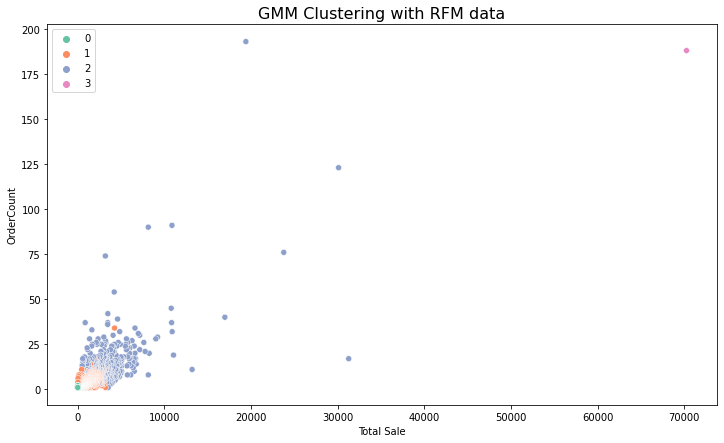

In [18]:
#Visualize the clusters
plt.figure(figsize = (12, 7))
sns.scatterplot(x = 'Monetary', y = 'Frequency', data = X,  hue = 'Group', palette = 'Set2')
plt.xlabel('Total Sale')
plt.ylabel('OrderCount')
plt.legend()
plt.title("GMM Clustering with RFM data", size = 16)
plt.savefig("gmm.png")
plt.plot()

In [19]:
fig = px.scatter_3d(X, x='Recency', y='Frequency', z='Monetary',
                    color = 'Group', opacity=0.5, title = "GMM Clustering with RFM data")
fig.update_traces(marker=dict(size=5),
                  
                  selector=dict(mode='marker'))
fig.show()

- The GMM model result for original data similar with KMeans original data also,  we can see there are similarity in defining the group of customer.
    - Group 1 (Small/individual customer) - 86%: this group have the least amount of Order and Profit.
    - Group 0 - 11% (Medium customer): this group have the profit at the medium (2300 mean).
    - Group 3 - 3.21% (Big customer): this group have both Total Sale and OrderCount or one of them high.
    - Group 2 - 0.2% (VIP customer): this group have both Total Sale and OrderCount really high.
- The GMM cluster for original data based on frequency and monetary rather than Recency.

In [39]:
rfm_agg.to_csv("gmm_agg.csv")

# RFM minmaxscaler data

In [21]:
X_minmax = pd.read_csv('rfm_minmax.csv', index_col = 0)

In [22]:
X_minmax.head()

,Recency,Frequency,Monetary
0,0.002681,0.973958,1.000000
1,0.010724,0.083333,0.445102
2,0.002681,0.635417,0.428486
3,0.010724,0.390625,0.338439
4,0.000000,1.000000,0.276195


In [23]:
list_sil = []   #danh sach gia tri sil
K = range(2,15)  #danh sach k
for k in K:
  gmm = GaussianMixture(n_components=k)
  gmm.fit(X_minmax)
  labels = gmm.predict(X_minmax)
  sil = metrics.silhouette_score(X_minmax, labels, metric = 'euclidean')
  list_sil.append(sil)

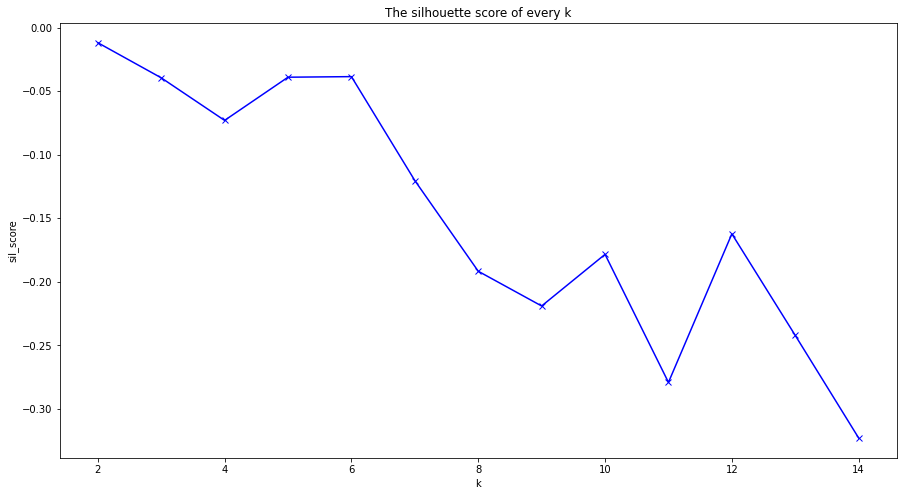

In [24]:
plt.figure(figsize = (15,8))
plt.plot(K, list_sil, 'bx-')
plt.xlabel('k')
plt.ylabel('sil_score')
plt.title('The silhouette score of every k')
plt.show()

The silhouette score for RFM minmaxscale data is k = 5

In [25]:
#select k = 5
gmm = GaussianMixture(n_components=5)
gmm.fit(X_minmax)

GaussianMixture(n_components=5)

In [26]:
print('==============Density==============')
print(gmm.weights_)                           #Density can bang nhau (nen)
print('==============Mean==============')
print(gmm.means_)
print('==============Covariance==============')
print(gmm.covariances_)

==============Density==============
[0.28402984 0.36620422 0.17023618 0.03218486 0.1473449 ]
==============Mean==============
[[0.0594558  0.01414863 0.01026155]
 [0.44313923 0.00087791 0.00258033]
 [0.31213386 0.00813027 0.0074692 ]
 [0.01541075 0.12681227 0.07901358]
 [0.10624191 0.03662101 0.02975439]]
==============Covariance==============
[[[ 1.74070812e-03 -9.59394359e-05 -3.19120522e-05]
  [-9.59394359e-05  1.05595335e-04  4.38405611e-05]
  [-3.19120522e-05  4.38405611e-05  4.48182578e-05]]

 [[ 9.03321897e-02 -5.68502203e-05 -3.20490617e-05]
  [-5.68502203e-05  4.80619247e-06  6.25553593e-07]
  [-3.20490617e-05  6.25553593e-07  3.97708734e-06]]

 [[ 4.13641506e-02  3.82461796e-05  1.10312438e-04]
  [ 3.82461796e-05  3.14368413e-05  4.06869594e-06]
  [ 1.10312438e-04  4.06869594e-06  2.06876255e-05]]

 [[ 1.98305380e-04 -4.20386895e-04 -1.50579227e-04]
  [-4.20386895e-04  1.85991244e-02  1.00356268e-02]
  [-1.50579227e-04  1.00356268e-02  1.08642017e-02]]

 [[ 1.19202955e-02 -6.

In [27]:
types = gmm.predict(X_minmax)
types

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

In [28]:
#add cluster value into datataframe new column
X['Group_minmax'] = types

In [29]:
X.head()

,Recency,Frequency,Monetary,Group,Group_minmax
CustomerID,,,,,
14911.0,1,188,70245.51,3,3
14096.0,4,17,31267.34,2,3
17841.0,1,123,30100.22,2,3
13089.0,4,76,23774.91,2,3
12748.0,0,193,19402.70,2,3


In [30]:
X['Group_minmax'].value_counts()

1    1637
0    1255
4     593
2     553
3     107
Name: Group_minmax, dtype: int64

In [31]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg_minmax = X.groupby('Group_minmax').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg_minmax.columns = rfm_agg_minmax.columns.droplevel()
rfm_agg_minmax.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg_minmax['Percent'] = round((rfm_agg_minmax['Count']/rfm_agg_minmax.Count.sum())*100, 2)

# Reset the index
rfm_agg_minmax = rfm_agg_minmax.reset_index()

In [33]:
fig = px.scatter_3d(X, x='Recency', y='Frequency', z='Monetary',
                    color = 'Group_minmax', opacity=0.5, title = "GMM Clustering with Minmax RFM data")
fig.update_traces(marker=dict(size=5),
                  
                  selector=dict(mode='marker'))
fig.show()

- The cluster result for minmaxscale data quite better than original data but the cluster group still overlapping with each other. The point is this model (GMM) still define cluster group without Recency score.
- Because the recency score will give us which customer is loss or new.
- The KMeans and Mini batch KMeans for minmaxscale data do it better.

In [38]:
rfm_agg_minmax.to_csv("gmm_agg_minmax.csv")

In [36]:
fig = px.scatter(rfm_agg_minmax, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Group_minmax",
           hover_name="Group_minmax", size_max=100, title = "Minmax data Group based on Monetary and Recency")
fig.show()

- This plot showed that those cluster circle does not overlap until we look at 3d plot.
- The mean recency affected by its value so the numbers in this chart are very modest.
##### In my conclusion, the GMM model does not fit well with the data in this case.